<a href="https://colab.research.google.com/github/trunghq0205/python4ds/blob/main/final_project_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----

# Báo cáo cuối kỳ môn Python cho Khoa học Dữ liệu

Nhóm - Tên thành viên:
1. Huỳnh Quang Trung - 20280108
2. Trần Tuấn Thái - 20280082
3. Hỏa Ngọc Tú
4. Hồ Ngọc Ân

Github: https://github.com/trunghq0205/python4ds

----

## Thông tin bài nộp

----

## Mô tả bài toán và nguồn gốc của tập dữ liệu

Đây là bộ dữ liệu về thông tin các chuyến taxi tại New York vào 6 tháng đầu năm 2016 dựa trên dữ liệu **[2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data)** có sẵn trên BigQuery của Google Cloud Platform. Dữ liệu gốc được phát hành bởi NYC *Taxi and Limousine Commission (TLC)* và có sẵn trên trang [NYC TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Tập dữ liệu được dùng trong đồ án lần này đã được lấy mẫu (sample) và tiền xử lý để dành riêng cho cuộc thi **[New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)** trên Kaggle vào năm 2017.

Mục tiêu của cuộc thi *New York City Taxi Trip Duration* là xây dựng một mô hình dự đoán tổng thời gian đi của các chuyến taxi ở Thành phố New York dựa vào các biến như thời gian đón, tọa độ địa lý, số lượng hành khách và một số biến số khác.

**Input:** Dữ liệu gồm 9 thuộc tính của một chuyến taxi (id, vendor_id, pickup_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag) \
**Output:** Tổng thời gian dự đoán của chuyến đó tính bằng giây.

***Ghi chú***: Mặc dù tập test chỉ có 9 thuộc tính, tập train có 11 thuộc tính, trong đó 1 thuộc tính là trip_duration, còn lại 1 thuộc tính không có trong tập test là dropoff_datetime. Cuộc thi quyết định không loại cột này ra khỏi tập train để cung cấp tập mở rộng các biến và thí sinh sử dụng tùy ý trong quá trình làm việc.

----

## Cài đặt và gọi các thư viện cần thiết

In [ ]:
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install geopy
# # Bỏ comment để cài đặt thư viện cần thiết cho câu 3
#!pip install sklearn
#!pip install xgboost
#!pip install pickle-mixin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
import seaborn as sns
plt.style.use('ggplot')

----

## Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

In [ ]:
taxi_df = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/train.csv', index_col = None)
test = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv', index_col = None)
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

In [ ]:
num_rows = taxi_df.shape[0]
num_cols = taxi_df.shape[1]
print(f'Tập dữ liệu train bao gồm {num_rows} dòng và {num_cols} cột.')

Tập dữ liệu train bao gồm 1458644 dòng và 11 cột.


Trong đó, mỗi dòng của tập dữ liệu là một bản ghi của một chuyến taxi theo 11 thuộc tính với các ý nghĩa khác nhau sẽ được trình bày chi tiết trong phần mô tả phía dưới.

### Dữ liệu có các dòng bị lặp không?

In [ ]:
taxi_df.duplicated().unique()

array([False])

Như vậy, trong tập dữ liệu của chúng ta không có các dòng dữ liệu bị trùng lặp với nhau.

### Mô tả ý nghĩa của các thuộc tính.

Tập dữ liệu huấn luyện đã xử lý gồm 11 cột, cột cuối cùng (trip_duration) là target: \
**id** - một mã định danh duy nhất cho mỗi chuyến đi \
**vendor_id** - mã cho biết nhà cung cấp được liên kết với hồ sơ chuyến đi (vì thông tin không được thu thập và cung cấp bởi TLC mà được cung cấp bởi 2 nhà cung cấp khác nhau được đánh số là 1 và 2) \
**pickup_datetime** - Ngày và giờ khi đồng hồ của taxi bắt đầu tính số mét \
**dropoff_datetime** - ngày và giờ khi kết thúc tính số mét \
**passenger_count** - số hành khách trên phương tiện (tài xế nhập thông tin này) \
**pickup_longitude** - kinh độ nơi bắt đầu tính số kilomet \
**pickup_latitude** - vĩ độ nơi bắt đầu tính số mét \
**dropoff_longitude** - kinh độ nơi kết thúc tính số kilomet \
**dropoff_latitude** - vĩ độ nơi kết thúc tính số mét \
**store_and_fwd_flag** - đánh dấu 1 bản ghi có được ghi lại trong bộ nhớ của phương tiện trước khi được gửi đến cho nhà cung cấp không (điều này xảy ra vì phương tiện không có kết nối đến máy chủ khi di chuyển) \
**trip_duration** - thời gian của chuyến tính bằng giây

### Các thuộc tính mang kiểu dữ liệu gì?

In [ ]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


**Nhận xét**: Ở đây, có 4 thuộc tính mang kiểu dữ liệu object là id, pickup_datetime, dropoff_datetime và store_and_fwd_flag. Ta tiếp tục tiến hành xem các kiểu dữ liệu có trong các thuộc tính này.

Ta sẽ tiến hàn viết một hàm để xem từng đối tượng trong các cột trên sẽ mang kiểu dữ liệu gì?

In [ ]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update((s.apply(lambda temp: type(temp))))
    return dtypes

In [ ]:
print(open_object_dtype(taxi_df['id']))
print(open_object_dtype(taxi_df['pickup_datetime']))
print(open_object_dtype(taxi_df['dropoff_datetime']))
print(open_object_dtype(taxi_df['store_and_fwd_flag']))

{<class 'str'>}
{<class 'str'>}
{<class 'str'>}
{<class 'str'>}


Tất các các phần tử tại các thuộc tính này đều mang kiểu dữ liệu là string. Để tiếp tục bài toán, tại đây ta có thể đưa ra các hướng giải quyết như sau:
- Đối với **id**: Đây đơn giản chỉ là một mã định danh cho mỗi chuyến taxi nên ta có thể giữ nguyên kiểu dữ lieuj của nó là string.
- Đối với **pickup_datetime** và **dropoff_datetime**: Ta sẽ chuyển chúng sang kiểu dữ liệu date_time để phù hợp với ngữ cảnh dữ liệu mà nó lưu trữ
- Đối với **store_and_fwd_flag**: Đây là cột mang ý nghĩa phân loại và đánh dấu, ta sẽ chuyển nó sang kiểu bool.

## Tiền xử lý dữ liệu

Dựa vào các quyết định ở phía trên, đầu tiên ta sẽ:
1. Chuyển **pickup_datetime** và **dropoff_datetime** về kiểu date_time
2. Chuyển **store_and_fwd_flag** về kiểu bool
3. Chuyển cột **id** sang kiểu dữ liệu str

### Chuyển cột **pickup_datetime** và **dropoff_datetime** sang datetime

In [ ]:
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

### Chuyển cột **store_and_fwd_flag** sang kiểu bool

In [ ]:
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].apply(lambda temp: False if temp == 'N' else True)

### Chuyển cột **id** sang kiểu dữ liệu str

In [ ]:
taxi_df['vendor_id'] = taxi_df['vendor_id'].astype(str)

Ta xem lại kiểu dữ liệu của các cột sau khi được xử lý

In [ ]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  object        
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  bool          
 10  trip_duration       1458644 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 112.7+ MB


### Thêm cột distance vào tập dữ liệu

Dựa vào tọa độ điểm đón và trả khách được cung cấp trong tập dữ liệu, ta sẽ tiến hành tính khoảng cách di chuyển của chuyến xe dựa trên khoảng cách euclid bằng cách sử dụng thư viện bổ trợ là geopy. Khoảng cách tính được ở đơn vị km

In [ ]:
def get_distance(trip):
    pickup_coord = (trip['pickup_latitude'], trip['pickup_longitude'])
    dropoff_coord = (trip['dropoff_latitude'], trip['dropoff_longitude'])
    return geopy.distance.distance(pickup_coord, dropoff_coord).km

In [ ]:
#UNCOMMENT TO TUN CODE
# Bỏ dấu comment để chạy code, ở đây để tiết kiệm thời gian nhóm đã chạy trước và sẽ lấy kết quả có được
# để thực hiện các bước tiếp theo.
#distances = taxi_df.apply(get_distance, axis=1)
#distances.to_csv('distance.csv', index=False)

In [ ]:
taxi_df['distance'] = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/distance.csv')

In [ ]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,1.502172
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,1.808660
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,6.379687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,429,1.483632
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,435,1.187038


## Khám phá dữ liệu (tiếp tục)

### Ở phần này, ta sẽ bắt đầu tìm hiểu riêng các thuộc tính của tập dữ liệu

In [ ]:
nume_col_df = taxi_df[["passenger_count", "pickup_datetime", "dropoff_datetime","pickup_latitude", "pickup_longitude", "dropoff_latitude", \
                      "dropoff_longitude", "trip_duration", "distance"]]

In [ ]:
def missing_ratio(s):
    return s.isna().mean() * 100

In [ ]:
nume_col_df = nume_col_df.agg([missing_ratio, min, max]);
nume_col_df

,passenger_count,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_duration,distance
missing_ratio,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
min,0.0,2016-01-01 00:00:17,2016-01-01 00:03:31,34.359695,-121.933342,32.181141,-121.933304,1.0,0.000000
max,9.0,2016-06-30 23:59:39,2016-07-01 23:02:03,51.881084,-61.335529,43.921028,-61.335529,3526282.0,1240.510256


Dựa vào bảng kết quả trên ta có nhận xét như sau:
- Tất cả các thuộc tính đều không có giá trị Na (giá trị bị thiếu)
- Có chuyến đi với số lượng hành khách thấp nhất là 0 và cao nhất là 9 người. Chúng ta sẽ tìm hiểu vấn đề này trong phan tiếp theo.
- Có chuyến đi với thời gian di chuyển chỉ là 1 giây với quãng đường di chuyển là 0 km. Đây là chuyến đi với thời gian ngắn bất thường
- Có chuyến đi với thời gian di chuyển là 3526282 giây với quãng đường di chuyển lên tới 1240.510256 km. Đây là chuyến đi có thời gian dài bất thường.

### Khảo sát cột **passenger_count**

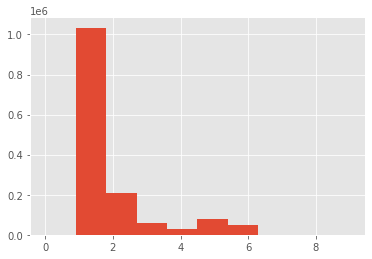

In [ ]:
plt.hist(taxi_df['passenger_count']);

In [ ]:
taxi_df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Nhận xét:
- Ta thấy phần lớn các chuyến đi sẽ có số lượng là 1 hành khách với 1033540 bản ghi, tiếp sau đó là 2 người với 210318 bản ghi. Đối với các chuyến đi có từ 3 đến 6 hành khách cũng có số lượng nhất định nằm trong khoảng từ 30000 đến 80000 bản ghi
- Ta cũng thấy có 60 chuyến đi với số lượng là 0 hành khách, đối với các chuyến có 7 8 9 hành khách cũng có rất ít bản ghi.

Vì tồn tại các dòng dữ liệu với các số liệu bất thường, đồng thời chúng cũng chiếm phần thiểu số trong tập dữ liệu, nên ta quyết định sẽ xóa bỏ các dòng có số lượng hành khách là 0, 7, 8 và 9.

### Khảo sát cột "trip_duration"

In [ ]:
taxi_df["trip_duration"].sort_values(ascending=False)[:15]

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
1221666      86378
91717        86378
1138915      86377
66346        86377
1284067      86369
Name: trip_duration, dtype: int64

Nhận xét:
- Có 4 chuyến đi với với thời lượng di chuyển khá lớn từ gần 2 triệu giây đến hơn 3.5 triệu giây.
- Ngoài 4 chuyến đi với thời lượng di chuyển rất lớn ở phía trên, thì các chuyến đi còn lại trong tập dữ liệu của chúng ta sẽ có trip_duration không vượt quá 86400.

Tiếp theo, ta sẽ quan sát sự phân bố về số lượng các chuyến taxi có **trip_duration** nằm trong các khoảng (0-6000) giây, (6000, 18000), (18000, 36000), (36000, 80000), (36000, 80000) và (80000, 86400)

Text(0, 0.5, 'count')

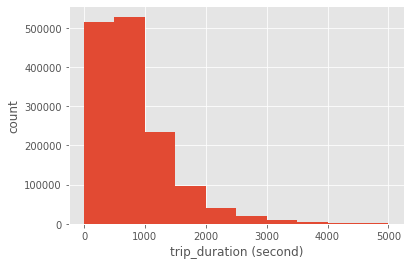

In [ ]:
plt.hist(taxi_df['trip_duration'], range=(0, 5000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

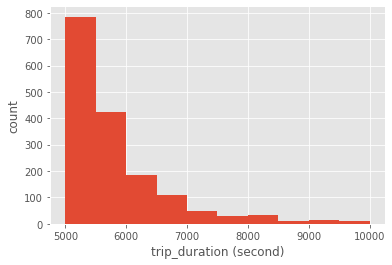

In [ ]:
plt.hist(taxi_df['trip_duration'], range=(5000, 10000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

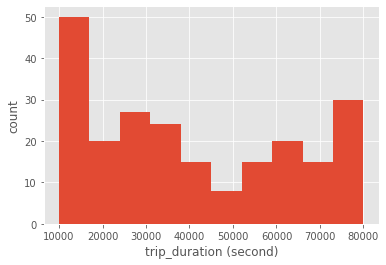

In [ ]:
plt.hist(taxi_df['trip_duration'], range=(10000, 80000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

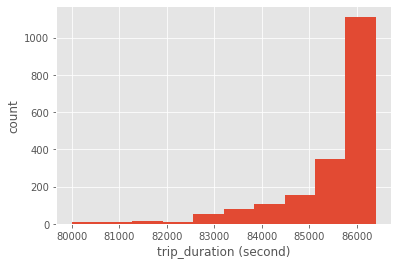

In [ ]:
plt.hist(taxi_df['trip_duration'], range=(80000, 86400))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

**Nhận xét:**
- Các chuyến đi trong tập dữ liệu phần lớn có trip_duration từ 3000 giây trở về trước với số lượng bản ghi khổng lồ so với các miền giá trị còn lại. Chỉ riêng với khoảng từ 0 tới 1000 đã có tới hơn 1 triệu bản ghi trong khi tập dữ liệu chỉ gần 1 triệu rưỡi dòng.
- Trong khoảng từ 10000 giây đến 80000 giây chúng ta có khá ít bản ghi.
- Trong khoảng từ 80000 giây đến 86400 giây: Nhận thấy từ cột mốc khoảng hơn 82500 đến 86400, số lượng bản ghi có xu hướng tăng. Đây là một trip_duration vô cùng lớn vì nó kéo dài tới gần 1 ngày (quá dài so với 1 chuyến taxi thông thường trong một thành phố). Ta nhận thấy rằng khi thời lượng của trip_duration càng lớn thì số lượng bản ghi sẽ có xu hướng giảm đi. Điều này là hợp lý vì thời lượng của các chuyến taxi thường không dài đến thế và các chuyến đi này chỉ là thiểu số hoặc không tồn tại ở ngoài thực tế. Vì vậy, việc các chuyến taxi có trip_duration tới gần 1 ngày tăng lên bất ngờ như thế là một bất thường.

Ngoài các chuyến đi quá dài thì chúng ta cũng cần quan tâm đến các chuyến đi có độ dài quá ngắn. Ta sẽ xem số lượng các chuyến đi có trip_duration bé hơn 200 giây

Text(0, 0.5, 'count')

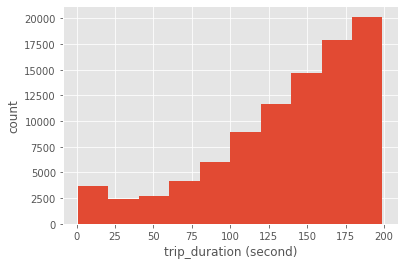

In [ ]:
plt.hist(taxi_df[taxi_df["trip_duration"] < 200]['trip_duration'])
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

**Quyết định xóa các bản ghi có trip_duration lớn hơn 82500 giây và 4 chuyến đi có độ dài dị biệt mà ta đã tìm ra ở phía trên.**